# Developping a Borrower Scoring Algorithm

Last updated : September 25th, 2022

## Introduction

During this project, I will use a dataset provided by a consumer finance companies to develop a machine learning algorithm that will predict if the borrower will have payment difficulties or not.

## 1. Data Loading and Filtering

First we will load the necessary packages and dataset and then we will carry on with the Cleaning and Analysis.

### 1.1 Loading our packages

We will import the necessary packages to run this project: matplotlib, numpy, pandas, seaborn.
Since I am running the project on Windows, I will also use sklearnex to increase the speed of sklearn.

In [30]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

#Importing Intel extension for sklearn to improve speed
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### 1.2 Loading the dataset

We will now load the dataset

In [31]:
app_test = pd.read_csv("Data/application_test.csv", sep=",")
app = pd.read_csv("Data/application_train.csv", sep=",")

app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

### 1.3 Feature Filtering

We will begin by removing features that have more than 50% na values :

In [32]:
#Increasing maximum number of info rows 
pd.options.display.max_info_columns = 130

#First we will define a function that drops columns that are null in more than x% of our database
def drop_na_columns(df: pd.DataFrame, percent: float):
    n = len(df)
    cutoff = n*percent/100
    for c in df.columns:
        if len(df[c].dropna()) < cutoff:
            df.drop(columns={c}, inplace=True)

#Dropping columns with less than 50% complete fields
drop_na_columns(app, 50)

len(app.columns)

app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307511 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  object 
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  int64  
 7   AMT_INCOME_TOTAL              307511 non-null  float64
 8   AMT_CREDIT                    307511 non-null  float64
 9   AMT_ANNUITY                   307499 non-null  float64
 10  AMT_GOODS_PRICE               307233 non-null  float64
 11  NAME_TYPE_SUITE               306219 non-null  object 
 12  NAME_INCOME_TYPE              307511 non-nul

In [33]:
#Counting the number of target vs not target variables:
app["TARGET"].value_counts(normalize=True)

#We have a significant difference in the number of data for both cases

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

## 2. Data Preparation

We will now clean our dataset.

### 2.1 Cleaning categorical variables

We will begin the cleaning process by cleaning categorical variables.

In [34]:
#Looking at unique valeus of categorical variables
def investigate_categories(df: pd.DataFrame):
    for c in df.columns:
        if df[c].dtype == 'object':
            print("Column",c)
            print("Unique values: {}".format(df[c].unique()))
            print("")
            print("-----------------------------------")
            
investigate_categories(app)

Column NAME_CONTRACT_TYPE
Unique values: ['Cash loans' 'Revolving loans']

-----------------------------------
Column CODE_GENDER
Unique values: ['M' 'F' 'XNA']

-----------------------------------
Column FLAG_OWN_CAR
Unique values: ['N' 'Y']

-----------------------------------
Column FLAG_OWN_REALTY
Unique values: ['Y' 'N']

-----------------------------------
Column NAME_TYPE_SUITE
Unique values: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']

-----------------------------------
Column NAME_INCOME_TYPE
Unique values: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']

-----------------------------------
Column NAME_EDUCATION_TYPE
Unique values: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

-----------------------------------
Column NAME_FAMILY_STATUS
Unique values: ['Single / not married' 'Married' 'C

In [35]:
#Investigating "XNA" values in GENDER
app[app["CODE_GENDER"] == 'XNA']
#Only 4 rows

#Let's look at the test data
app_test[app_test["CODE_GENDER"] == 'XNA']
#0 row

#We will delete the rows with NA values from our dataset
app = app[app["CODE_GENDER"] != 'XNA']

In [36]:
#Investigating "XNA" values in ORGANIZATION_TYPE
app[app["ORGANIZATION_TYPE"] == 'XNA']
#55374 rows

app[app["ORGANIZATION_TYPE"] == 'XNA']["TARGET"].value_counts(normalize=True)
#Significant deviation from the normal percentages, so it is interesting to keep these values

#They will be encoded during the feature engineering part of the project

0    0.946004
1    0.053996
Name: TARGET, dtype: float64

In [37]:
#Looking at "nan" values in EMERGENCYSTATE_MODE
print(len(app[app["EMERGENCYSTATE_MODE"].isna()]))

app[app["EMERGENCYSTATE_MODE"].isna()]["TARGET"].value_counts(normalize=True)
#Here it represents about half our dataset, we will create a "NA" variable as well since there is a small deviation from what
#We would have expected

app.loc[app["EMERGENCYSTATE_MODE"].isna(),"EMERGENCYSTATE_MODE"] = 'UKN'

145754


In [38]:
#Looking at "nan" values in OCCUPATION TYPE
print(len(app[app["OCCUPATION_TYPE"].isna()]))

app[app["OCCUPATION_TYPE"].isna()]["TARGET"].value_counts(normalize=True)
#Here it represents about a third of our dataset, we will create a "NA" variable as well since there is a deviation from what
#we would have expected

app.loc[app["OCCUPATION_TYPE"].isna(),"OCCUPATION_TYPE"] = 'UKN'

96389


In [39]:
#Looking at "nan" values in NAME_TYPE_SUITE
print(len(app[app["NAME_TYPE_SUITE"].isna()]))
#Only 1292 NA values

#We will delete these rows
app = app[app["NAME_TYPE_SUITE"].notna()]

1292


In [ ]:
#We can see that WEEKDAY_APPR_PROCESS_START is coded as a string

import time
#Let's convert it into week day number
app["WEEKDAY_APPR_PROCESS_START"] = app["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: time.strptime(x, '%A').tm_wday)

In [40]:
#Verifying that we've dealt with all missing values of categorical variables
for c in app.columns:
    if app[c].dtype == 'object':
        print(app[c].isna().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0


We have finished cleaning up categorical variables, now we will look at numeric variables 

### 2.2 Cleaning numeric variables 

In [41]:
#Looking for outliers 

#Increasing the number of maximum columns shown
pd.options.display.max_columns = 100
app.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,306215.000000,306215.000000,306215.000000,3.062150e+05,3.062150e+05,306203.000000,3.062150e+05,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,3.055560e+05,245464.000000,156794.000000,153795.000000,156794.000000,153795.000000,156794.000000,153795.000000,158364.000000,305194.000000,305194.000000,305194.000000,305194.000000,306214.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,264805.000000,264805.000000,264805.000000,264805.000000,264805.000000,264805.000000
mean,278164.519246,0.080842,0.417004,1.687830e+05,5.987997e+05,27122.210470,5.379479e+05,0.020865,-16040.633855,63858.968166,-4987.987728,-2994.331035,0.999997,0.819767,0.199050,0.998126,0.280764,0.056797,2.152778,2.052617,2.031638,12.061999,0.015163,0.050749,0.040619,0.078164,0.230492,0.179599,5.143519e-01,0.510923,0.977728,0.226261,0.977056,0.222292,0.977746,0.225877,0.102525,1.421532,0.143374,1.404605,0.100005,-964.425634,0.000042,0.710560,0.000082,0.014715,0.087857,0.000140,0.081342,0.003854,0.000020,0.003840,0.000007,0.003406,0.002805,0.001130,0.009405,0.000261,0.007818,0.000571,0.000493,0.000330,0.006390,0.006982,0.034448,0.267616,0.265697,1.903903
std,102786.814894,0.272593,0.722104,2.375179e+05,4.019606e+05,14490.897429,3.689186e+05,0.013830,4362.856052,141313.558266,3522.557759,1509.518082,0.001807,0.384382,0.399286,0.043255,0.449373,0.231454,0.910584,0.509103,0.502794,3.266155,0.122199,0.219484,0.197405,0.268430,0.421148,0.383854,1.910904e-01,0.194836,0.059251,0.144579,0.064624,0.143649,0.059927,0.145009,0.107424,2.400847,0.446637,2.379730,0.362213,826.707866,0.006516,0.453503,0.009035,0.120410,0.283087,0.011849,0.273359,0.061957,0.004426,0.061852,0.002556,0.058262,0.052890,0.033595,0.096523,0.016161,0.088073,0.023899,0.022201,0.018158,0.083791,0.110479,0.204792,0.915624,0.794827,1.869584
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.00000

In [42]:
#DAYS_BIRTH, DAYS_REGISTRATION and DAYS_ID_PUBLISH only have negative values
app["DAYS_REGISTRATION"] = abs(app["DAYS_REGISTRATION"])
app["DAYS_ID_PUBLISH"] = abs(app["DAYS_ID_PUBLISH"])
app["DAYS_BIRTH"] = abs(app["DAYS_BIRTH"])

print(app["DAYS_BIRTH"].min()/365, app["DAYS_BIRTH"].max()/365)
#No outlier data

20.517808219178082 69.12054794520547


In [43]:
#Turning SK_ID_CURR into an ID field :
app.set_index('SK_ID_CURR', inplace=True)

app.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,-637,3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,-1188,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,19046,-225,4260.0,2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,19005,-3039,9833.0,2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,19932,-3038,4311.0,3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Analysis of the describe() output shows that there is **no clear outlier** in the rest of the numeric data. We can now start handling missing values.

In [44]:
len(app.columns[app.isnull().any()])
#21 columns with NA values

#Dropping rows with more than 30% na values
def drop_na_rows(df: pd.DataFrame, pct: float):
    n = len(df.columns)
    cutoff = n*pct/100 
    df = df[df.isna().sum(axis=1) > cutoff]

drop_na_rows(app, 50)
#No row was removed


We've now finished cleaning incorrect values. 
Before starting to perform data imputation, we need to perform a **train/validation/test split**. This will **prevent us from introducing data leakage during the cleaning process**. 

### 2.3 Performing train / test / validation split

We will divide our dataset as such : 

-  80% train set 
-  10% validation 
-  10% test

We will be able to revisit this values during the hyperparameter tuning part of the project.

In [150]:
from sklearn.model_selection import train_test_split

y = app["TARGET"]
ID = app.index
X = app.drop(columns={"TARGET"})

#Splitting train and test sets, we have to add indices to conserve the original index
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, ID, test_size=0.1, shuffle=True, random_state=8)

#Assigning the correct indices (the SK_IDs) to y_test
y_test.index = indices_test

#Applying the same function to separate train and validation set
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_train, y_train, indices_train, test_size = 0.1/0.9, shuffle=True, random_state=8)

#Assigning the SK IDs to y_train and y_val
y_train.index = indices_train
y_val.index = indices_val

In [151]:
print(len(X_train), len(X_test), len(X_val))
#Our test and validation set have the same length and its 10% of the overall length of X

244971 30622 30622


In [47]:
X_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
398944,Cash loans,M,N,N,1,225000.0,225000.0,13045.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.032561,11603,-1169,5254.0,3958,1,1,0,1,1,0,Managers,3.0,1,1,SATURDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.787646,0.605836,0.9921,0.7500,0.9866,0.6250,0.9921,0.7500,0.7283,No,0.0,0.0,0.0,0.0,-2217.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
372814,Cash loans,F,N,Y,0,157500.0,592560.0,25236.0,450000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.018850,18376,-351,3056.0,1871,1,1,0,1,0,0,Core staff,2.0,2,2,SATURDAY,14,0,0,0,0,0,0,School,0.669711,0.309275,0.9950,0.3333,0.9950,0.3333,0.9950,0.3333,0.1832,No,6.0,0.0,6.0,0.0,-2641.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
125664,Cash loans,F,N,Y,0,67500.0,175896.0,9337.5,126000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018634,17129,-300,6303.0,680,1,1,0,1,0,0,Cleaning staff,2.0,2,2,THURSDAY,11,0,0,0,0,1,1,Government,0.462526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,0.0,0.0,0.0,0.0,-187.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
403086,Cash loans,M,N,Y,0,225000.0,1527579.0,53226.0,1395000.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.032561,19858,-374,7326.0,3399,1,1,0,1,1,0,Security staff,2.0,1,1,FRIDAY,19,0,0,0,0,0,0,Transport: type 4,0.614510,0.513694,0.9861,0.3333,0.9861,0.3333,0.9861,0.3333,0.2135,No,0.0,0.0,0.0,0.0,-1003.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
272892,Cash loans,F,Y,Y,0,135000.0,1074861.0,35653.5,963000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.030755,17465,-2505,4592.0,964,1,1,0,1,0,0,Sales staff,2.0,2,2,THURSDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.645919,0.240541,0.9896,0.3333,0.9896,0.3333,0.9896,0.3333,0.1824,No,8.0,0.0,8.0,0.0,-1688.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


Now that we have performed the split, we can carry on to perform data imputation.

These operations will also have to be performed on the test and train_set, so we will create a function that we will be able to apply to the 3 sets.

### 2.4 Data Imputation

First we will investigate what columns still have missing values. 
Normally, we have replaced all missing features for categorical variables.

In [152]:
#For ease of use, we will rename X_train to df so we can better replicate our code afterwards
df = X_train.copy()

def check_col_nas_type(df: pd.DataFrame):
    type_cols = []
    #Verifying the type of columns with missing values
    for c in df.columns[df.isna().any()].tolist():
        if ~np.isin(df[c].dtype, type_cols):
            type_cols.append(df[c].dtype)
    return(type_cols)

check_col_nas_type(df)
#This verifies that we only need to perform data imputation on numeric features

[dtype('float64')]

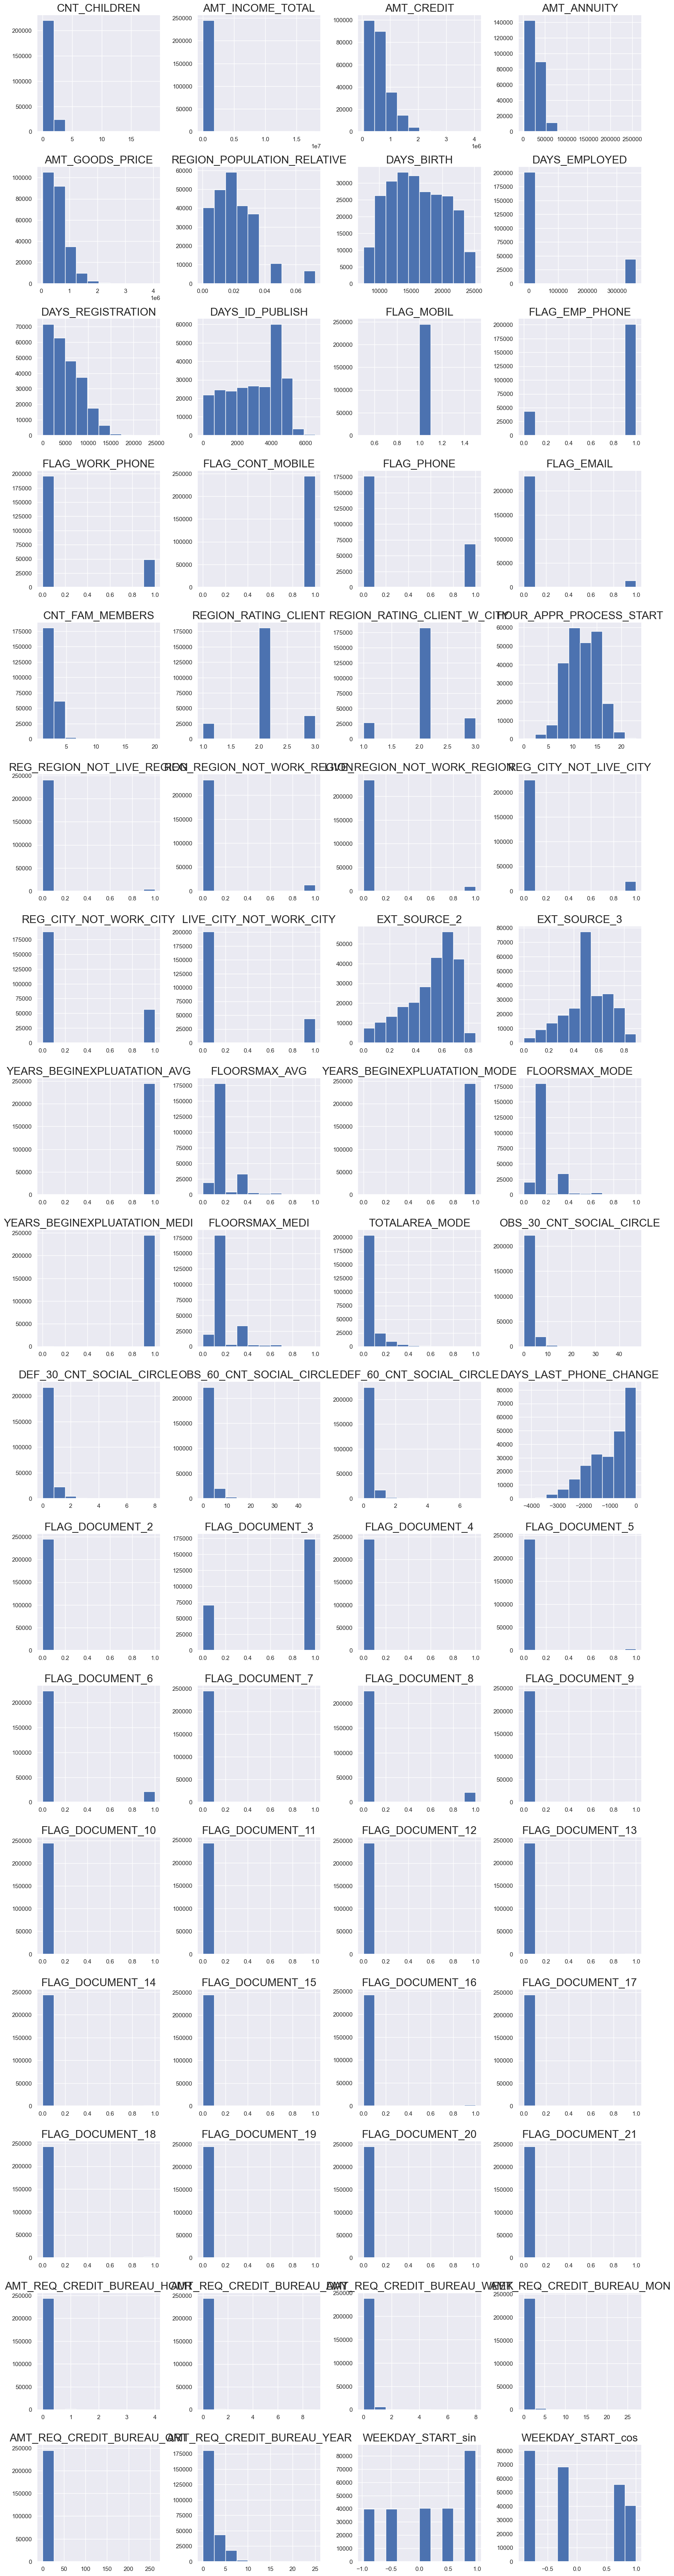

In [22]:
#Loading visualization functions present in the functions.py file
from functions import *

#Visualizing distribution of all numeric variables
histPlotAll(df)

#Apart from HOUR_APPR_PROCESS_START, all numeric variables seem to be not normally distributed

In [153]:
from scipy import stats

#Defining a data imputation function, we will use the NAME_CONTRACT_TYPE as a category_column

#This data_imputation script can be improved during the hyperparameter setting phase

def numeric_data_imputation(df: pd.DataFrame, category_column: str):
    
    #Creating a copy of our dataset
    df_imput = df.copy()
    #Creating a list of columns with missing values
    missing_cols = df.columns[df.isna().any()].tolist()
    max_unique_values = 3
    
    #Iterating over columns with missing data
    for c in missing_cols:
        
        #Verifying that we are in a numeric column
        if np.issubdtype(df[c].dtype,np.number):
            
            #If there are less or equal to max unique values, we will use mode imputation 
            if len(df[c].unique()) <= max_unique_values:
                            
                #We will create a subset from our categorical variable and perform mode imputation
                for t in df[category_column].unique():
                    #Creating subset
                    subset = df.loc[df[category_column] == t]
                    
                    #Calculating mode of subset
                    mode = subset[c].mode().values[0]
                    
                    #Applying imputation
                    df.loc[(df[c].isna()) & (df[category_column] == t), c] = mode
                    
            #If we have more numeric values, we will calculate the Kolmogorov Smirnoff pvalue to test for normalization
            else:
                
                #Normalizing target variable
                norm = c + '_norm'
                df_imput[norm] = (df_imput[c] - np.mean(df_imput[c].dropna())) / np.std(df_imput[c].dropna())

                #Calculating pvalue of KS test
                pval = stats.kstest(df_imput[norm].dropna(), 'norm').pvalue
                
                if pval >= 0.05:
                    #P value is superior to 0.05, we cannot reject the null hypothesis and thus conclude the variable is
                    #approximatively normally distributed
                    #We will use mean imputation on that variable
                    for t in df[category_column].unique():
                        #Creating subset
                        subset = df.loc[df[category_column] == t]

                        #Calculating mean based on that subset and our target column
                        mean = subset[c].mean()

                        #Applying imputation
                        df.loc[(df[c].isna()) & (df[category_column] == t), c] = mean
                else:
                    #P value is inferior to 0.05, we can reject the null hypothesis and thus conclude the variable is
                    #not normally distributed
                    #We will use median imputation on that variable
                    for t in df[category_column].unique():
                        #Creating subset
                        subset = df.loc[df[category_column] == t]

                        #Calculating mean based on that subset and our target column
                        med = subset[c].median()

                        #Applying imputation
                        df.loc[(df[c].isna()) & (df[category_column] == t), c] = med
    return None

#Applying the function to our 3 sets (X_train has been renamed to df)
numeric_data_imputation(df, 'NAME_CONTRACT_TYPE')
numeric_data_imputation(X_test, 'NAME_CONTRACT_TYPE')
numeric_data_imputation(X_val, 'NAME_CONTRACT_TYPE')

#Checking for nulls in our 3 sets
for data in [df,X_test,X_val]:
    print(np.count_nonzero(data.isnull()))
    
#We have no more NA values in all 3 sets

0
0
0


Now that we have 3 complete datasets, we can perform **feature engineering**

## 3. Feature Engineering

We will begin by converting the categorical variables into numbers

### 3.1 Encoding categorical variables

For variables with a small number of categories, we will perform **One-Hot Encoding**.

If there are more than 10 categories, we will perform **Weight of Evidence (WoE) encoding** instead to avoid a sharp increase in the dimensionality of our dataset.

In [175]:
import category_encoders as ce

def encode_cat_vars(df: pd.DataFrame, X_train: pd.DataFrame, y_train, max_categ: int):
    woe_cols = []
    ohe_cols = []
    for c in df.columns:
        
        #Keeping only categorical columns
        if not np.issubdtype(df[c].dtype,np.number):
            
            #If more than X categories, performing WOE encoding
            if len(df[c].unique()) >= max_categ:
                woe_cols.append(c)
            
            else: 
                #One hot encoding and remove the original column
                ohe_cols.append(c)
                
    #Defining WOE Encoder and fitting it to the TRAIN dataset
    encoder = ce.WOEEncoder(cols = woe_cols).fit(X_train[woe_cols], y_train)
    #Fitting the encoder to the selected dataframe
    encoded_cols = encoder.transform(df[woe_cols]).add_suffix('_woe')
    
    #Joining the selected dataframe and the target dataframe
    df = df.join(encoded_cols).drop(columns=woe_cols)
    
    #Performing one hot encoding on selected columns
    df = pd.get_dummies(df, columns=ohe_cols)
    return df

#Just a reminder that once again df = X_train
#We apply all this function to our 3 sets
df = encode_cat_vars(df, df, y_train, 10)
X_test = encode_cat_vars(df, df, y_train, 10)
X_val = encode_cat_vars(df, df, y_train, 10)

In [179]:
def check_dtypes(df: pd.DataFrame):
    type_cols = []
    for c in df.columns:
        if not np.isin(df[c].dtype, type_cols):
            type_cols.append(df[c].dtype)
    print(type_cols)

check_dtypes(df)
check_dtypes(X_test)
check_dtypes(X_val)

[dtype('int64'), dtype('float64'), dtype('uint8')]
[dtype('int64'), dtype('float64'), dtype('uint8')]
[dtype('int64'), dtype('float64'), dtype('uint8')]


We have verified that all of our 3 sets are composed only of numeric features. 

We will now use **cyclical features encoding** to better represent features that are 

### 3.3 Encoding Cyclical Features

We have 2 columns with time features that are cyclical in nature but coded with numbers.

To increase the performance of our algorithm, we will 

In [ ]:
#Now we encode it into angular distance to preseve the day intervals
app["WEEKDAY_START_sin"] = np.sin(app["WEEKDAY_APPR_PROCESS_START"] * (2 * np.pi/7))
app["WEEKDAY_START_cos"] = np.cos(app["WEEKDAY_APPR_PROCESS_START"] * (2 * np.pi/7))

#We then remove the weekday column
app.drop(columns={"WEEKDAY_APPR_PROCESS_START"}, inplace=True)

#Same process for HOUR_APPR_PROCESS_START
app["HOUR_START_sin"] = np.sin(app["HOUR_APPR_PROCESS_START"] * (2 * np.pi/24))
app["HOUR_START_cos"] = np.cos(app["HOUR_APPR_PROCESS_START"] * (2 * np.pi/24))

#We then remove the hour column
app.drop(columns={"HOUR_APPR_PROCESS_START"}, inplace=True)

## 4. Resampling our training dataset

As we've seen at the beginning of this part, our dataset has a very big imbalance with 92% of rows with the TARGET = 0 and only 8% with the Target variable equal to 1.

To reduce this imbalance, we will perform SMOTE oversampling on our minority class.

Of course, **oversampling will only be performed on our train set**.

In [81]:
#Importing imblearn to be able to apply SMOTE oversampling
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)

X_train_res, y_train_res = sm.fit_resample(df, y_train)

X_train_res.values_counts(normalize=True)

ValueError: could not convert string to float: 'Cash loans'

In [ ]:
import time
#We can see that WEEKDAY_APPR_PROCESS_START is coded as a string

#Let's convert it into time of day
app["WEEKDAY_APPR_PROCESS_START"] = app["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: time.strptime(x, '%A').tm_wday)

#Now we encode it into angular distance to preseve the day intervals
app["WEEKDAY_START_sin"] = np.sin(app["WEEKDAY_APPR_PROCESS_START"] * (2 * np.pi/7))
app["WEEKDAY_START_cos"] = np.cos(app["WEEKDAY_APPR_PROCESS_START"] * (2 * np.pi/7))

#We then remove the weekday column
app.drop(columns={"WEEKDAY_APPR_PROCESS_START"}, inplace=True)

#Same process for HOUR_APPR_PROCESS_START
app["HOUR_START_sin"] = np.sin(app["HOUR_APPR_PROCESS_START"] * (2 * np.pi/24))
app["HOUR_START_cos"] = np.cos(app["HOUR_APPR_PROCESS_START"] * (2 * np.pi/24))

#We then remove the hour column
app.drop(columns={"HOUR_APPR_PROCESS_START"}, inplace=True)